In [3]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

Solving linear variational problem.


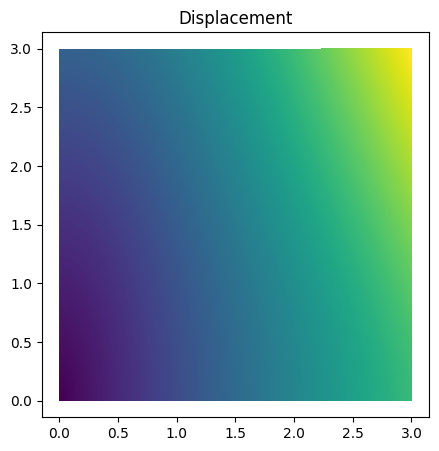

In [5]:
# Define boundary condition

E = 210e3 # 210GPa
nu = 0.3
lambda_ = E*nu/((1+nu)*(1-2*nu))
mu = E/(2*(1+nu))

Lmax = Constant(3) # 3mm
n_mesh = 200

# Side loading
m = 10 # 10N/mm
b = 50 # 50N


mesh = RectangleMesh(Point(0, 0), Point(Lmax, Lmax), n_mesh, n_mesh)
V = VectorFunctionSpace(mesh, 'P', 1)

tol = 1E-14

def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], Lmax, tol)

bc1 = DirichletBC(V.sub(0), Constant(0), left_boundary)
bc2 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc = [bc1, bc2]

#mark right boundary
right = AutoSubDomain(right_boundary)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
right.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
# f = (0, -x[0]/Lmax)
f = Constant((0, 0))

# T = Constant((pstress, 0))
T = Expression(('m*x[1]+b','0'), degree=1, m=m, b=b)
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
plt.figure(figsize=(5, 5))
plot(u, title='Displacement', mode='displacement')
plt.axis('equal')

tensor_space = TensorFunctionSpace(mesh, 'P', 1)
strain = project(epsilon(u), tensor_space)
stress = project(sigma(u), tensor_space)


# V = FunctionSpace(mesh, 'P', 1)
# s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
# von_Mises = sqrt(3./2*inner(s, s))
# von_Mises = project(von_Mises, V)
# plt.figure(figsize=(5, 5))
# plot(von_Mises, title='Stress intensity')



# # Compute magnitude of displacement
# u_magnitude = sqrt(dot(u, u))
# u_magnitude = project(u_magnitude, V)



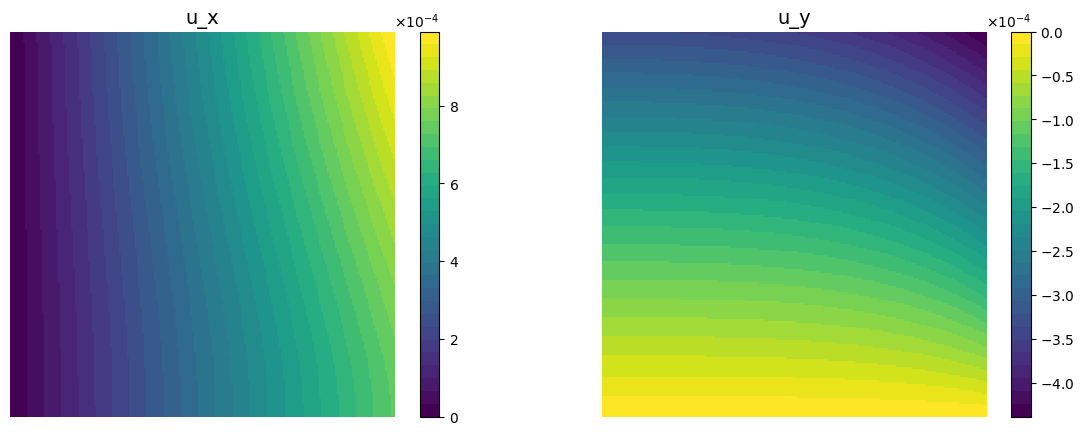

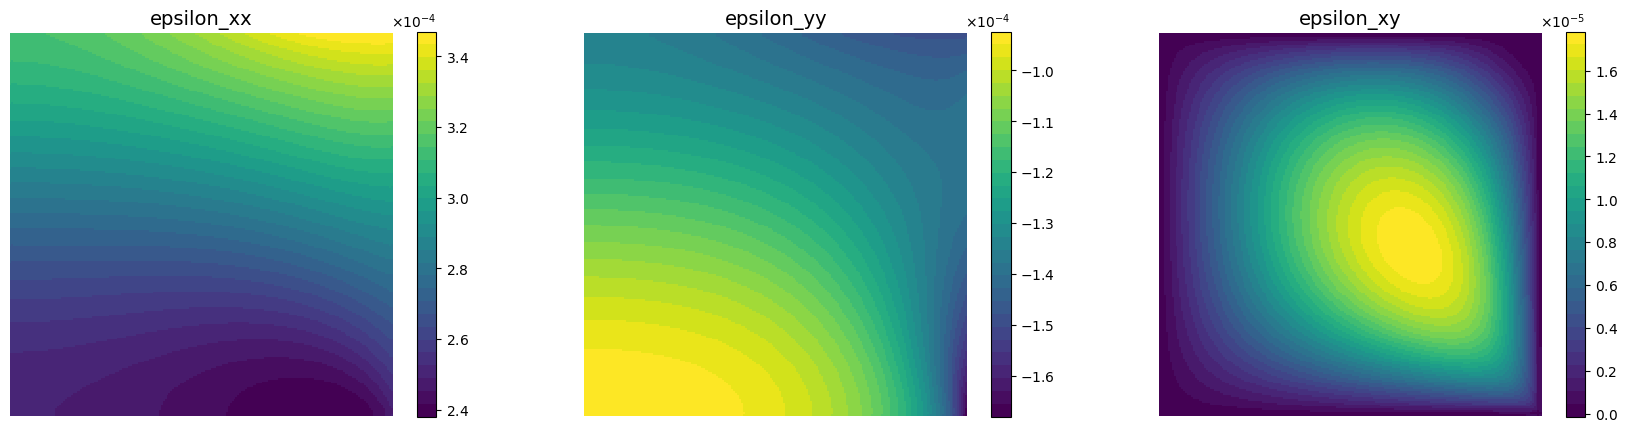

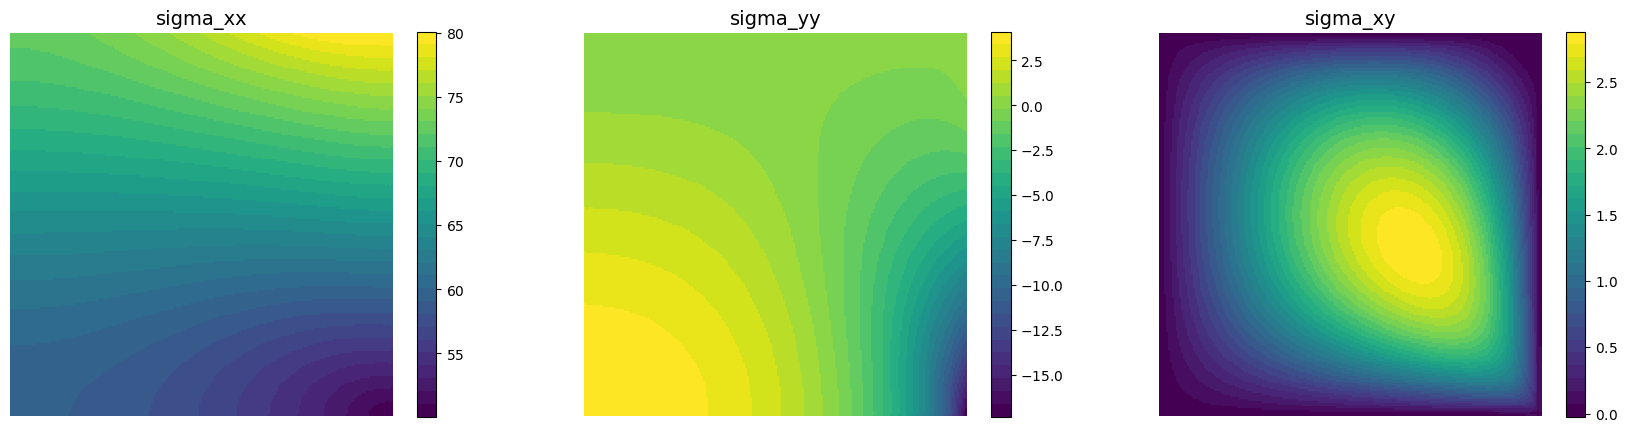

In [47]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt



def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'off',colorbar=True,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    fig.colorbar(im, ax=AX, format=formatter)
    return im

cmap = plt.get_cmap('viridis')
num_colors = 30
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)

n_mesh_points = 200

x_plot = np.linspace(0, 3, n_mesh_points)
y_plot = np.linspace(0, 3, n_mesh_points)
X, Y = np.meshgrid(x_plot, y_plot)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

u_val = np.array([u(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain_val[:,0], strain_val[:,3], 0.5*(strain_val[:,1]+strain_val[:,2])]).T
stress_val = np.array([stress(X_grid[i, :]) for i in range(X_grid.shape[0])])
stress_val = np.array([stress_val[:,0], stress_val[:,3], 0.5*(stress_val[:,1]+stress_val[:,2])]).T

# # Plot displacement
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im = pcolor_plot(ax[0], X, Y, u_val[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, u_val[:,1].reshape(X.shape), "u_y",colormap=cmap)

# # Plot strain
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
im = pcolor_plot(ax[0], X, Y, strain_val[:,0].reshape(X.shape), "epsilon_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_val[:,1].reshape(X.shape), "epsilon_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_val[:,2].reshape(X.shape), "epsilon_xy",colormap=cmap)

# Plot stress
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
im = pcolor_plot(ax[0], X, Y, stress_val[:,0].reshape(X.shape), "sigma_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, stress_val[:,1].reshape(X.shape), "sigma_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, stress_val[:,2].reshape(X.shape), "sigma_xy",colormap=cmap)

plt.show()


In [ ]:
# Save solution 
data_dir = "data/"
data_path = f"{data_dir}fem_solution_{n_mesh_points}_points.dat"
np.savetxt(data_path, np.hstack((X_grid, u_val, strain_val, stress_val)), delimiter=" ")

In [7]:
from scipy.interpolate import RegularGridInterpolator

# Load solution
n_mesh_points = 200
data_dir = "data/"
data_path = f"{data_dir}fem_solution_{n_mesh_points}_points.dat"

data = np.loadtxt(data_path)
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

n_mesh_points = int(np.sqrt(X_val.shape[0]))

# Interpolate solution
x_grid = np.linspace(0, 3, n_mesh_points)
y_grid = np.linspace(0, 3, n_mesh_points)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_points, n_mesh_points).T)
    interpolators.append(interp)

solution_fn = lambda x, y: np.array([interp((x, y)) for interp in interpolators]).T

(40000, 5)

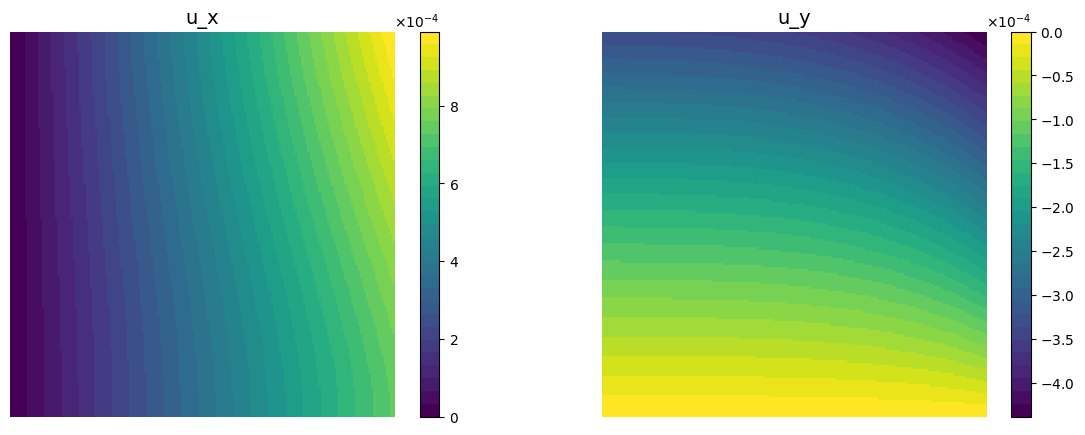

In [48]:
# Check interpolation
n_plot_points = 177
x_plot = np.linspace(0, 3, n_plot_points)
y_plot = np.linspace(0, 3, n_plot_points)
X, Y = np.meshgrid(x_plot, y_plot)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

solution_plot = solution_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im = pcolor_plot(ax[0], X, Y, solution_plot[:,0].reshape(X.shape), "u_x",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, solution_plot[:,1].reshape(X.shape), "u_y",colormap=cmap)